MSDS 458-Assignment 1: Sunny Yurasek

#### Overview

You will have gathered and preprocessed your data, designed and refined your network structure, trained and tested the network, varied the hyperparameters to improve performance and analyzed/assessed the results. 
In summary, I am trying to fit a number of neural networks, comparing processing time and performance across experimental treatments.

#### Management Question

Suppose you are asked to develop a neural network model for digit classification. How would you go about training such a model? How would you judge the model's accuracy in digit classification with real data examples, such as customer or client handwritten digits on paper?

Note: Some code below adapted from Géron (2017) Python notebook code 

### Load Libraries

In [1]:
%matplotlib inline
import numpy as np
import os
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
from collections import OrderedDict
from matplotlib.backends.backend_pdf import PdfPages  # plot to pdf files
import time #to time how long models take to run 

In [2]:
import tensorflow as tf
import keras

C:\Users\sedwards\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#jupyter display options
pd.set_option('display.notebook_repr_html', True) 
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 

# Plot Options
plt.style.use('seaborn')
plt.rc('font', size=14)
plt.rc('figure', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('axes', titlesize=14)

In [4]:
# to make this notebook's output stable across runs
seed=42

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

#### Load MNIST Data

In [5]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [6]:
#predictors -- reshape, standardize and convert to float32 
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0

#convert labels to float32
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [7]:
#define validation sets (only for TensorFLow models)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [8]:
print('Train Feature Shape: ', X_train.shape)
print('Train Label Shape: ', y_train.shape)
print('Test Feature Shape: ', X_test.shape)
print('Test Label Shape: ', y_test.shape)
print('Validation Feature Shape: ', X_valid.shape)
print('Validation Label Shape: ', y_valid.shape)

Train Feature Shape:  (55000, 784)
Train Label Shape:  (55000,)
Test Feature Shape:  (10000, 784)
Test Label Shape:  (10000,)
Validation Feature Shape:  (5000, 784)
Validation Label Shape:  (5000,)


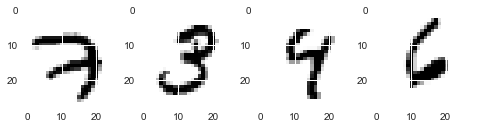

In [9]:
#training set as visual:
_, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(X_train[0].reshape(28, 28));
ax2.imshow(X_train[1].reshape(28, 28));
ax3.imshow(X_train[2].reshape(28, 28));
ax4.imshow(X_train[3].reshape(28, 28));

### Neural Networks 

In [10]:
#function to shuffle batch sizes
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [11]:
n_inputs = 28*28  # MNIST image shape 28x28 = 784

Network 1: TF Network with One Hidden Layers (200), ReLU Activation, Gradient Descent Optimizer
Adapted from Géron (2017) Python notebook code

In [12]:
#reset graph 
reset_graph()

#define placeholder variables as float32
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y") 

In [13]:
#define architecture as two hidden layers and relu activation 
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, units=200, name="hidden1",         #first hidden layer, 200 nodes, relu activation 
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden1, units=10, name="outputs")     #output layer, 10 categories, softmax for probabilities 
    y_proba = tf.nn.softmax(logits)                                 #apply softmax to outputs for probabilities 

In [14]:
#specify cross-entropy loss function 
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [15]:
#specify learning rate 
learning_rate = 0.01

#specify Gradient Descent optimizer at 0.01 learning rate 
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [16]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [18]:
batch_size = 100
n_epochs = 20
n_batches = 50

#start a timer 
start_time_nn1 = time.time()

#set up a dataframe for training results
data_nn1 = pd.DataFrame([])

#train network
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        loss_batch = loss.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        loss_valid = loss.eval(feed_dict={X: X_valid, y: y_valid})
        data_nn1 = data_nn1.append(pd.DataFrame({'Epoch': epoch+1, 'Batch Accuracy': acc_batch,'Batch Loss': loss_batch, 'Validation Accuracy': acc_valid,'Validation Loss': loss_valid}, index=[0]), ignore_index=True)

    save_path_nn1 = saver.save(sess, "./my_model_nn1.ckpt")

#end timer
total_time_nn1 = time.time() - start_time_nn1

print("The Neural Network TF 1 took %.4f seconds to train." % (total_time_nn1))

#print results dataframe
data_nn1

The Neural Network TF 1 took 33.4730 seconds to train.


Batch Accuracy  Batch Loss  Epoch  Validation Accuracy  Validation Loss
0             0.87    0.605484      1               0.8628         0.585078
1             0.92    0.345394      2               0.8910         0.421212
2             0.89    0.501438      3               0.9022         0.362331
3             0.92    0.370274      4               0.9122         0.329746
4             0.93    0.303183      5               0.9158         0.309182
5             0.91    0.393272      6               0.9194         0.293610
6             0.95    0.204159      7               0.9230         0.279495
7             0.92    0.280382      8               0.9286         0.268912
8             0.93    0.224036      9               0.9304         0.259851
9             0.91    0.262487     10               0.9334         0.252018
10            0.93    0.311492     11               0.9342         0.243988
11            0.94    0.189087     12               0.9362         0.236722
12            0.92    0.314366     13               0.9376         0.230973
13            0.96    0.188586     14               0.9382         0.224455
14            0.95    0.192909     15               0.9390         0.219252
15            0.92    0.292283     16               0.9410         0.213724
16            0.97    0.142696     17               0.9434         0.209029
17            0.94    0.219951     18               0.9438         0.204869
18            0.92    0.231517     19               0.9446         0.199862
19            0.90    0.268534     20               0.9464         0.195603

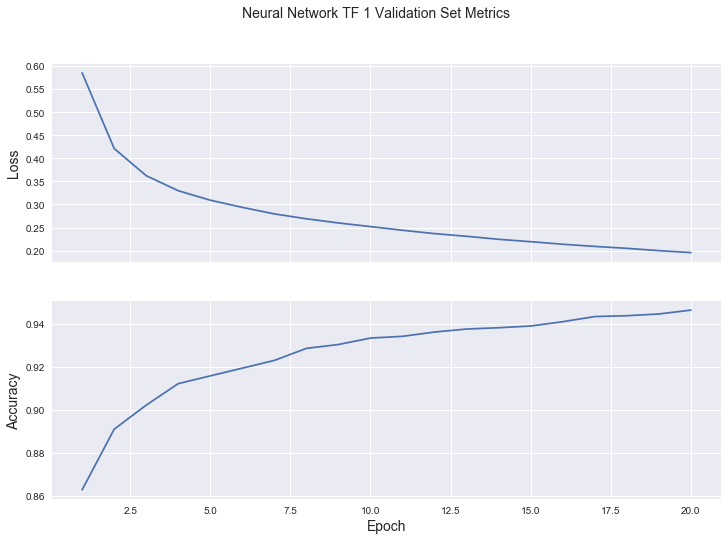

In [19]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Neural Network TF 1 Validation Set Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(data_nn1['Epoch'],data_nn1['Validation Loss'])

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(data_nn1['Epoch'],data_nn1['Validation Accuracy']);

In [20]:
#Evaluate model on test set
with tf.Session() as sess:
    saver.restore(sess, save_path_nn1)
    accuracy_val_nn1 = accuracy.eval(feed_dict={X: X_test, y: y_test})
    loss_val_nn1 = loss.eval(feed_dict={X: X_test, y: y_test})
    
print("")    
print("The Neural Network TF 1 Test Set Accuracy %.4f " % (accuracy_val_nn1))
print("The Neural Network TF 1 Test Set Loss %.4f " % (loss_val_nn1))
print("The Neural Network TF 1 took %.4f seconds to train." % (total_time_nn1))

INFO:tensorflow:Restoring parameters from ./my_model_nn1.ckpt

The Neural Network TF 1 Test Set Accuracy 0.9422 
The Neural Network TF 1 Test Set Loss 0.2047 
The Neural Network TF 1 took 33.4730 seconds to train.


### Network 2: TF Network with Two Hidden Layers (200, 200), ReLU Activation, and Gradient Descent Optimizer
Adapted from Géron (2017) Python notebook code

In [21]:
#reset graph 
reset_graph()

#define placeholder variables as float32
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y") 

In [22]:
#define architecture as two hidden layers and relu activation 
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, units=200, name="hidden1",         #first hidden layer, 200 nodes, relu activation 
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, units=200, name="hidden2",   #second hidden layer, 200 nodes, relu activation 
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, units=10, name="outputs")     #output layer, 10 categories, softmax for probabilities 
    y_proba = tf.nn.softmax(logits)                                 #apply softmax to outputs for probabilities 

In [23]:
#specify cross-entropy loss function 
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [24]:
#specify learning rate 
learning_rate = 0.01

#specify Gradient Descent optimizer at 0.01 learning rate 
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [25]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [26]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [27]:
batch_size = 100
n_epochs = 20
n_batches = 50

#start a timer 
start_time_nn2 = time.time()

#set up a dataframe for training results
data_nn2 = pd.DataFrame([])

#train network
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        loss_batch = loss.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        loss_valid = loss.eval(feed_dict={X: X_valid, y: y_valid})
        data_nn2 = data_nn2.append(pd.DataFrame({'Epoch': epoch+1, 'Batch Accuracy': acc_batch,'Batch Loss': loss_batch, 'Validation Accuracy': acc_valid,'Validation Loss': loss_valid}, index=[0]), ignore_index=True)

    save_path_nn2 = saver.save(sess, "./my_model_nn2.ckpt")

#end timer
total_time_nn2 = time.time() - start_time_nn2    
    
#print the end time 
print("The Neural Network TF 2 took %.4f seconds to train." % (total_time_nn2))

#print results dataframe
data_nn2

The Neural Network TF 2 took 45.3980 seconds to train.


Batch Accuracy  Batch Loss  Epoch  Validation Accuracy  Validation Loss
0             0.87    0.570020      1               0.8632         0.553806
1             0.92    0.297893      2               0.8984         0.382709
2             0.93    0.461300      3               0.9132         0.325223
3             0.90    0.293489      4               0.9202         0.292228
4             0.93    0.244600      5               0.9268         0.270216
5             0.92    0.358568      6               0.9296         0.255127
6             0.96    0.159807      7               0.9342         0.237335
7             0.93    0.213406      8               0.9390         0.225506
8             0.95    0.174728      9               0.9408         0.215741
9             0.94    0.190305     10               0.9446         0.206868
10            0.94    0.249471     11               0.9466         0.197571
11            0.96    0.144895     12               0.9494         0.188988
12            0.95    0.232075     13               0.9508         0.183987
13            0.96    0.144833     14               0.9534         0.175545
14            0.98    0.128996     15               0.9542         0.170010
15            0.93    0.239361     16               0.9558         0.163720
16            0.98    0.101830     17               0.9570         0.159681
17            0.96    0.146882     18               0.9566         0.156674
18            0.97    0.118459     19               0.9582         0.150499
19            0.92    0.205383     20               0.9602         0.145594

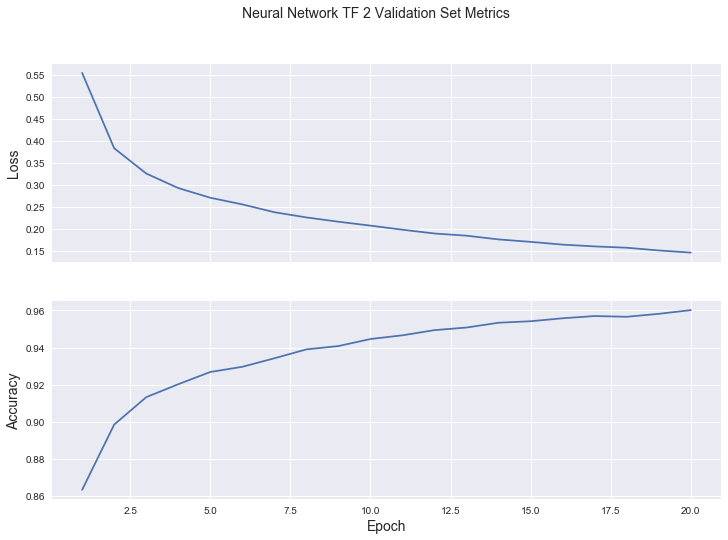

In [28]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Neural Network TF 2 Validation Set Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(data_nn2['Epoch'],data_nn2['Validation Loss'])

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(data_nn2['Epoch'],data_nn2['Validation Accuracy']);

In [29]:
#Evaluate model on test set
with tf.Session() as sess:
    saver.restore(sess, save_path_nn2)
    accuracy_val_nn2 = accuracy.eval(feed_dict={X: X_test, y: y_test})
    loss_val_nn2 = loss.eval(feed_dict={X: X_test, y: y_test})
    
print("")    
print("The Neural Network TF 2 Test Set Accuracy %.4f " % (accuracy_val_nn2))
print("The Neural Network TF 2 Test Set Loss %.4f " % (loss_val_nn2))
print("The Neural Network TF 2 took %.4f seconds to train." % (total_time_nn2))

INFO:tensorflow:Restoring parameters from ./my_model_nn2.ckpt

The Neural Network TF 2 Test Set Accuracy 0.9550 
The Neural Network TF 2 Test Set Loss 0.1502 
The Neural Network TF 2 took 45.3980 seconds to train.


#### Comment:
Second model took less time to train, but we see a decrease in accuracy and increase in loss with the test data. 

### Network 3: TF Network with Three Hidden Layers (300, 200, 100), ReLU Activation, and Gradient Descent Optimizer
Adapted from Géron (2017) Python notebook code

In [30]:
#reset graph 
reset_graph()

#define placeholder variables as float32
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y") 

In [31]:
#define architecture as two hidden layers and relu activation 
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, units=300, name="hidden1",         #first hidden layer, 300 nodes, relu activation 
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, units=200, name="hidden2",   #second hidden layer, 200 nodes, relu activation 
                              activation=tf.nn.relu)
    hidden3 = tf.layers.dense(hidden1, units=100, name="hidden3",   #second hidden layer, 100 nodes, relu activation 
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, units=10, name="outputs")     #output layer, 10 categories, softmax for probabilities 
    y_proba = tf.nn.softmax(logits)                                 #apply softmax to outputs for probabilities 

In [32]:
#specify cross-entropy loss function 
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [33]:
#specify learning rate 
learning_rate = 0.01

#specify Gradient Descent optimizer at 0.01 learning rate 
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [34]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [35]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [36]:
batch_size = 100
n_epochs = 20
n_batches = 50

#start a timer 
start_time_nn3 = time.time()

#set up a dataframe for training results
data_nn3 = pd.DataFrame([])

#train network
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        loss_batch = loss.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        loss_valid = loss.eval(feed_dict={X: X_valid, y: y_valid})
        data_nn3 = data_nn3.append(pd.DataFrame({'Epoch': epoch+1, 'Batch Accuracy': acc_batch,'Batch Loss': loss_batch, 'Validation Accuracy': acc_valid,'Validation Loss': loss_valid}, index=[0]), ignore_index=True)


    save_path_nn3 = saver.save(sess, "./my_model_nn3.ckpt")

#end timer
total_time_nn3 = time.time() - start_time_nn3    
    
#print the end time 
print("The Neural Network TF 3 took %.4f seconds to train." % (total_time_nn3))

#print results dataframe
data_nn3

The Neural Network TF 3 took 61.8950 seconds to train.


Batch Accuracy  Batch Loss  Epoch  Validation Accuracy  Validation Loss
0             0.88    0.552071      1               0.8768         0.500279
1             0.92    0.289348      2               0.9014         0.360165
2             0.92    0.482531      3               0.9134         0.312412
3             0.91    0.304196      4               0.9214         0.282173
4             0.93    0.253578      5               0.9280         0.262054
5             0.91    0.351380      6               0.9320         0.248132
6             0.96    0.144830      7               0.9360         0.230816
7             0.93    0.185827      8               0.9404         0.217816
8             0.95    0.156205      9               0.9428         0.208758
9             0.93    0.198777     10               0.9446         0.199307
10            0.94    0.229761     11               0.9476         0.189569
11            0.94    0.148386     12               0.9502         0.181267
12            0.96    0.233227     13               0.9532         0.176471
13            0.95    0.142197     14               0.9548         0.167608
14            0.98    0.115309     15               0.9560         0.162301
15            0.94    0.198611     16               0.9582         0.156085
16            0.98    0.091459     17               0.9586         0.150746
17            0.96    0.148663     18               0.9606         0.147844
18            0.96    0.143056     19               0.9610         0.142508
19            0.93    0.166222     20               0.9620         0.138288

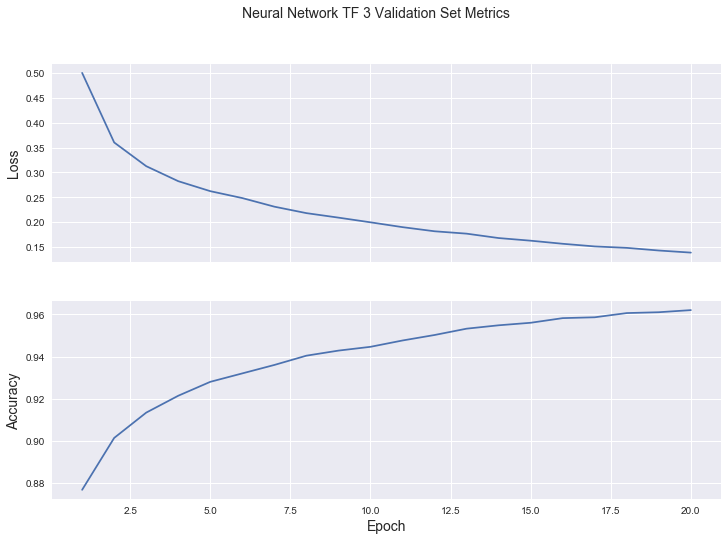

In [37]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Neural Network TF 3 Validation Set Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(data_nn3['Epoch'],data_nn3['Validation Loss'])

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(data_nn3['Epoch'],data_nn3['Validation Accuracy']);

In [38]:
#Evaluate model on test set
with tf.Session() as sess:
    saver.restore(sess, save_path_nn3)
    accuracy_val_nn3 = accuracy.eval(feed_dict={X: X_test, y: y_test})
    loss_val_nn3 = loss.eval(feed_dict={X: X_test, y: y_test})
    
print("")    
print("The Neural Network TF 3 Test Set Accuracy %.4f " % (accuracy_val_nn3))
print("The Neural Network TF 3 Test Set Loss %.4f " % (loss_val_nn3))
print("The Neural Network TF 3 took %.4f seconds to train." % (total_time_nn3))

INFO:tensorflow:Restoring parameters from ./my_model_nn3.ckpt

The Neural Network TF 3 Test Set Accuracy 0.9595 
The Neural Network TF 3 Test Set Loss 0.1406 
The Neural Network TF 3 took 61.8950 seconds to train.


#### Comment:

We added an extra layer to the third model. It looks like it took more time to train with only a slight increase to the Accuracy and decrease to Loss for the training set.

Network 4: TF Network with Three Hidden Layers (300, 200, 100), ReLU Activation, and Adam Optimizer
Adapted from Géron (2017) Python notebook code

In [39]:
#reset graph 
reset_graph()

#define placeholder variables as float32
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y") 

In [40]:
#define architecture as two hidden layers and relu activation 
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, units=300, name="hidden1",         #first hidden layer, 300 nodes, relu activation 
                              activation=tf.nn.relu)
    hidden2 = tf.layers.dense(hidden1, units=200, name="hidden2",   #second hidden layer, 200 nodes, relu activation 
                              activation=tf.nn.relu)
    hidden3 = tf.layers.dense(hidden1, units=100, name="hidden3",   #second hidden layer, 100 nodes, relu activation 
                              activation=tf.nn.relu)
    logits = tf.layers.dense(hidden2, units=10, name="outputs")     #output layer, 10 categories, softmax for probabilities 
    y_proba = tf.nn.softmax(logits)                                 #apply softmax to outputs for probabilities 

In [41]:
#specify cross-entropy loss function 
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [42]:
#specify learning rate 
learning_rate = 0.01

#specify Gradient Descent optimizer at 0.01 learning rate 
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [43]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [44]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [45]:
batch_size = 100
n_epochs = 20
n_batches = 50

#start a timer 
start_time_nn4 = time.time()

#set up a dataframe for training results
data_nn4 = pd.DataFrame([])

#train network
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        loss_batch = loss.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        loss_valid = loss.eval(feed_dict={X: X_valid, y: y_valid})
        data_nn4 = data_nn4.append(pd.DataFrame({'Epoch': epoch+1, 'Batch Accuracy': acc_batch,'Batch Loss': loss_batch, 'Validation Accuracy': acc_valid,'Validation Loss': loss_valid}, index=[0]), ignore_index=True)


    save_path_nn4 = saver.save(sess, "./my_model_nn4.ckpt")

#end timer
total_time_nn4 = time.time() - start_time_nn4    
    
#print the end time 
print("The Neural Network TF 4 took %.4f seconds to train." % (total_time_nn4))

#print results dataframe
data_nn4

The Neural Network TF 4 took 66.8230 seconds to train.


Batch Accuracy  Batch Loss  Epoch  Validation Accuracy  Validation Loss
0             0.96    0.145748      1               0.9526         0.165375
1             0.98    0.083945      2               0.9626         0.141387
2             0.97    0.109054      3               0.9644         0.128602
3             0.99    0.036513      4               0.9712         0.115665
4             0.98    0.108712      5               0.9664         0.140434
5             0.99    0.024517      6               0.9704         0.152025
6             0.99    0.071236      7               0.9702         0.135181
7             0.97    0.093379      8               0.9686         0.172049
8             1.00    0.008315      9               0.9684         0.143883
9             0.99    0.029008     10               0.9692         0.144378
10            0.96    0.095337     11               0.9654         0.163244
11            0.98    0.050147     12               0.9680         0.176269
12            0.99    0.011949     13               0.9692         0.161319
13            0.99    0.049979     14               0.9730         0.180661
14            1.00    0.000294     15               0.9728         0.154427
15            0.98    0.040064     16               0.9778         0.134210
16            1.00    0.011526     17               0.9776         0.149682
17            0.99    0.021152     18               0.9736         0.185426
18            0.99    0.023623     19               0.9730         0.216074
19            0.96    0.098490     20               0.9718         0.209150

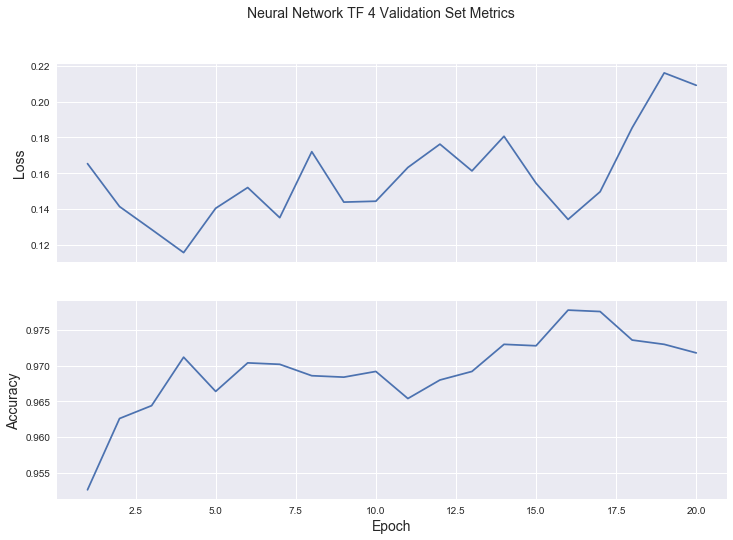

In [46]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Neural Network TF 4 Validation Set Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(data_nn4['Epoch'],data_nn4['Validation Loss'])

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(data_nn4['Epoch'],data_nn4['Validation Accuracy']);

In [47]:
#Evaluate model on test set
with tf.Session() as sess:
    saver.restore(sess, save_path_nn4)
    accuracy_val_nn4 = accuracy.eval(feed_dict={X: X_test, y: y_test})
    loss_val_nn4 = loss.eval(feed_dict={X: X_test, y: y_test})
    
print("")    
print("The Neural Network TF 4 Test Set Accuracy %.4f " % (accuracy_val_nn4))
print("The Neural Network TF 4 Test Set Loss %.4f " % (loss_val_nn4))
print("The Neural Network TF 4 took %.4f seconds to train." % (total_time_nn4))

INFO:tensorflow:Restoring parameters from ./my_model_nn4.ckpt

The Neural Network TF 4 Test Set Accuracy 0.9729 
The Neural Network TF 4 Test Set Loss 0.1986 
The Neural Network TF 4 took 66.8230 seconds to train.


#### Comment:

Model 4 shows a slight improvement over Model 2 when comparing Accuracy and Loss, but the model took longer to train. After looking at all 4 models we can conclude that adding an extra layer increases training time and only slightly improves the model's perfomance on the test data.

Models with Keras Sequential

In [48]:
from keras.models import Sequential, load_model
from keras.layers import Dense

##### Re-Load Data for Keras Models 
Note: The Keras models below use a train/test split rather than a train/test/validation split. 

In [49]:
(X_train_k, y_train_k), (X_test_k, y_test_k) = tf.keras.datasets.mnist.load_data()

In [50]:
#predictors -- reshape, standardize and convert to float32 
X_train_k = X_train_k.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test_k = X_test_k.astype(np.float32).reshape(-1, 28*28) / 255.0

#convert labels to float32
y_train_k = y_train_k.astype(np.int32)
y_test_k = y_test_k.astype(np.int32)

##### Re-shape Label Data for Keras Model 

In [51]:
#reshape label data 
n_classes = 10
print("Y_train before one-hot encoding: ", y_train_k.shape)

Y_train before one-hot encoding:  (60000,)


In [52]:
Y_train_k = keras.utils.to_categorical(y_train_k, n_classes)
Y_test_k = keras.utils.to_categorical(y_test_k, n_classes)
print("Y_train after one-hot encoding: ", Y_train_k.shape)
print("Y_test after one-hot encoding: ", Y_test_k.shape)

Y_train after one-hot encoding:  (60000, 10)
Y_test after one-hot encoding:  (10000, 10)


### Network 5: Keras Network with Two Hidden Layers (300, 100), ReLU Activation, and Adam Optimizer

Adapted from 'Deep Learning with Keras' by Chollet and from DataCamp

In [53]:
#reset graph 
reset_graph()

In [54]:
# Create keras model
keras_sequential = Sequential()

In [55]:
#add first hidden layer 
keras_sequential.add(Dense(300, activation='relu', input_shape=(784,)))

# Add second hidden layer
keras_sequential.add(Dense(100, activation='relu'))

# Add the output layer
keras_sequential.add(Dense(10, activation='softmax'))

In [56]:
# Compile the model
keras_sequential.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [57]:
#start a timer 
start_time_nn5 = time.time()

# Fit the model
results_nn5=keras_sequential.fit(X_train_k, Y_train_k, 
                     validation_data=(X_test_k, Y_test_k), 
                     epochs=20, 
                     batch_size=50,
                     verbose=1)


# saving the model
keras_sequential.save('keras_nn5.h5')
del keras_sequential

#end timer
total_time_nn5 = time.time() - start_time_nn5    

#print the end time 
print("The Neural Network Kera Model ADAM took %.4f seconds to train." % (total_time_nn5))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 8s 138us/step - loss: 0.2166 - acc: 0.9351 - val_loss: 0.1104 - val_acc: 0.9663
Epoch 2/20
60000/60000 [==============================] - 8s 131us/step - loss: 0.0856 - acc: 0.9738 - val_loss: 0.0740 - val_acc: 0.9768
Epoch 3/20
60000/60000 [==============================] - 9s 143us/step - loss: 0.0584 - acc: 0.9810 - val_loss: 0.0729 - val_acc: 0.9762
Epoch 4/20
60000/60000 [==============================] - 9s 146us/step - loss: 0.0428 - acc: 0.9869 - val_loss: 0.0850 - val_acc: 0.9744
Epoch 5/20
60000/60000 [==============================] - 8s 140us/step - loss: 0.0328 - acc: 0.9888 - val_loss: 0.0695 - val_acc: 0.9812
Epoch 6/20
60000/60000 [==============================] - 8s 138us/step - loss: 0.0258 - acc: 0.9914 - val_loss: 0.0755 - val_acc: 0.9790
Epoch 7/20
60000/60000 [==============================] - 9s 142us/step - loss: 0.0252 - acc: 0.9921 - val_loss: 0.0731 - 

In [58]:
# Create a list of 20 epoch instances 
epoch_list = list(range(1, 21))

#load keras results in a dataframe
data_nn5 = pd.DataFrame(
    {'Epoch': epoch_list,
     'Batch Accuracy': results_nn5.history['acc'],
     'Batch Loss': results_nn5.history['loss'],
     'Validation Accuracy': results_nn5.history['val_acc'],
     'Validation Loss': results_nn5.history['val_loss']
    })

#print results dataframe
data_nn5

Batch Accuracy  Batch Loss  Epoch  Validation Accuracy  Validation Loss
0         0.935117    0.216630      1               0.9663         0.110403
1         0.973783    0.085642      2               0.9768         0.073992
2         0.981017    0.058372      3               0.9762         0.072923
3         0.986850    0.042803      4               0.9744         0.084983
4         0.988817    0.032793      5               0.9812         0.069496
5         0.991400    0.025762      6               0.9790         0.075473
6         0.992050    0.025203      7               0.9809         0.073100
7         0.993767    0.018504      8               0.9808         0.076443
8         0.994133    0.016890      9               0.9809         0.073806
9         0.995217    0.014876     10               0.9818         0.077170
10        0.995733    0.012781     11               0.9813         0.085930
11        0.995333    0.013897     12               0.9807         0.087284
12        0.995933    0.012473     13               0.9809         0.088637
13        0.996300    0.011277     14               0.9806         0.096656
14        0.997267    0.009361     15               0.9818         0.086415
15        0.996617    0.010444     16               0.9827         0.083273
16        0.996783    0.010603     17               0.9821         0.087817
17        0.997333    0.008766     18               0.9811         0.093609
18        0.996633    0.009929     19               0.9833         0.093673
19        0.997867    0.006617     20               0.9806         0.100463

In [59]:
mnist_model = load_model('keras_nn5.h5')
loss_and_metrics = mnist_model.evaluate(X_test_k, Y_test_k, verbose=2)
accuracy_val_nn5 = loss_and_metrics[1]
loss_val_nn5 = loss_and_metrics[0]

#print the end time and accuracy
print("The Neural Network Kera Model ADAM Test Set Accuracy %.4f " % ( accuracy_val_nn5))
print("The Neural Network Kera Model ADAM Test Set Loss %.4f " % ( loss_val_nn5))
print("The Neural Network Kera Model ADAM took %.4f seconds to train." % (total_time_nn5))


The Neural Network Kera Model ADAM Test Set Accuracy 0.9806 
The Neural Network Kera Model ADAM Test Set Loss 0.1005 
The Neural Network Kera Model ADAM took 165.9670 seconds to train.


In [60]:
mnist_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


from keras.utils.vis_utils import plot_model
plot_model(mnist_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

pip install ann_visualizer
pip install graphviz

from ann_visualizer.visualize import ann_viz;

### Network 6: Keras Network with Two Hidden Layers (300, 100), ReLU Activation, and SGD Optimizer

In [61]:
#reset graph 
reset_graph()

In [62]:
from keras import backend as K
K.clear_session()

In [63]:
# Create keras model
keras_sequential = Sequential()

In [64]:
#add first hidden layer 
keras_sequential.add(Dense(300, activation='relu', input_shape=(784,)))

# Add second hidden layer
keras_sequential.add(Dense(100, activation='relu'))

# Add the output layer
keras_sequential.add(Dense(10, activation='softmax'))

In [65]:
# Compile the model
keras_sequential.compile(optimizer='sgd',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [66]:
#start a timer 
start_time_nn6 = time.time()

# Fit the model
results_nn6 = keras_sequential.fit(X_train_k, Y_train_k, 
                     validation_data=(X_test_k, Y_test_k), 
                     epochs=20, 
                     batch_size=50,
                     verbose=1)

# saving the model
keras_sequential.save('keras_nn6.h5')
del keras_sequential

#end timer
total_time_nn6 = time.time() - start_time_nn6 

#print the end time 
print("The Neural Network Kera Model SGD took %.4f seconds to train." % (total_time_nn6))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 6s 96us/step - loss: 0.7041 - acc: 0.8257 - val_loss: 0.3488 - val_acc: 0.9054
Epoch 2/20
60000/60000 [==============================] - 5s 88us/step - loss: 0.3208 - acc: 0.9093 - val_loss: 0.2776 - val_acc: 0.9238
Epoch 3/20
60000/60000 [==============================] - 5s 90us/step - loss: 0.2686 - acc: 0.9242 - val_loss: 0.2419 - val_acc: 0.9304
Epoch 4/20
60000/60000 [==============================] - 6s 94us/step - loss: 0.2357 - acc: 0.9336 - val_loss: 0.2195 - val_acc: 0.9379
Epoch 5/20
60000/60000 [==============================] - 5s 91us/step - loss: 0.2107 - acc: 0.9410 - val_loss: 0.2012 - val_acc: 0.9439
Epoch 6/20
60000/60000 [==============================] - 6s 93us/step - loss: 0.1902 - acc: 0.9463 - val_loss: 0.1813 - val_acc: 0.9482
Epoch 7/20
60000/60000 [==============================] - 6s 94us/step - loss: 0.1732 - acc: 0.9510 - val_loss: 0.1673 - val_acc

In [67]:
# Create a list of 20 epoch instances 
epoch_list = list(range(1, 21))

#load keras results in a dataframe
data_nn6 = pd.DataFrame(
    {'Epoch': epoch_list,
     'Batch Accuracy': results_nn6.history['acc'],
     'Batch Loss': results_nn6.history['loss'],
     'Validation Accuracy': results_nn6.history['val_acc'],
     'Validation Loss': results_nn6.history['val_loss']
    })

#print results dataframe
data_nn6


Batch Accuracy  Batch Loss  Epoch  Validation Accuracy  Validation Loss
0         0.825700    0.704081      1               0.9054         0.348800
1         0.909333    0.320767      2               0.9238         0.277584
2         0.924233    0.268569      3               0.9304         0.241917
3         0.933600    0.235650      4               0.9379         0.219491
4         0.940983    0.210653      5               0.9439         0.201154
5         0.946333    0.190161      6               0.9482         0.181304
6         0.951000    0.173170      7               0.9518         0.167324
7         0.954733    0.159157      8               0.9558         0.156538
8         0.959067    0.146780      9               0.9581         0.148621
9         0.961783    0.135977     10               0.9593         0.140810
10        0.964700    0.126669     11               0.9621         0.131382
11        0.967283    0.118218     12               0.9632         0.130088
12        0.969433    0.110780     13               0.9645         0.121745
13        0.971583    0.104079     14               0.9664         0.116035
14        0.973400    0.097990     15               0.9678         0.112223
15        0.974450    0.092509     16               0.9681         0.108472
16        0.976083    0.087533     17               0.9686         0.107609
17        0.977167    0.082643     18               0.9706         0.101762
18        0.978433    0.078591     19               0.9707         0.099915
19        0.979583    0.074596     20               0.9713         0.095922

In [68]:
mnist_model2 = load_model('keras_nn6.h5')
loss_and_metrics2 = mnist_model2.evaluate(X_test_k, Y_test_k, verbose=2)
accuracy_val_nn6 = loss_and_metrics2[1]
loss_val_nn6 = loss_and_metrics2[0]
#print the end time and accuracy
print("The Neural Network Kera Model SGD Test Set Accuracy %.4f " % (accuracy_val_nn6))
print("The Neural Network Kera Model SGD Test Set Loss %.4f " % (loss_val_nn6))
print("The Neural Network Kera Model SGD took %.4f seconds to train." % (total_time_nn6))


The Neural Network Kera Model SGD Test Set Accuracy 0.9713 
The Neural Network Kera Model SGD Test Set Loss 0.0959 
The Neural Network Kera Model SGD took 111.2810 seconds to train.


### Model Comparison

In [69]:
models = ['Model 1','Model 2','Model 3','Model 4','Model 5','Model 6']
library = ['TF','TF','TF','TF','Keras','Keras']
layers = [1,2,3,3,2,2]
dims = ['200','200,200','300,200,100','300,200,100','300,100','300,100']
act = ['relu','relu','relu','relu','relu','relu']
opt = ['GD','GD','GD','ADAM','ADAM','SGD']
accuracy_metric = [accuracy_val_nn1,accuracy_val_nn2,accuracy_val_nn3,accuracy_val_nn4,accuracy_val_nn5,accuracy_val_nn6]
time = [total_time_nn1,total_time_nn2,total_time_nn3,total_time_nn4,total_time_nn5,total_time_nn6]
loss = [loss_val_nn1,loss_val_nn2,loss_val_nn3,loss_val_nn4,loss_val_nn5,loss_val_nn6]

In [70]:
#load keras results in a dataframe
model_comparison = pd.DataFrame(
    {'Model': models,
     'Library': library,
     'Layers': layers,
     'Dimensions': dims,
     'Activation': act,
     'Optimizer': opt,
     'Accuracy':accuracy_metric,
     'Loss': loss,
     'Time (Seconds)': time
    })

In [71]:
model_comparison

Accuracy Activation   Dimensions  Layers Library      Loss    Model  \
0    0.9422       relu          200       1      TF  0.204669  Model 1   
1    0.9550       relu      200,200       2      TF  0.150177  Model 2   
2    0.9595       relu  300,200,100       3      TF  0.140589  Model 3   
3    0.9729       relu  300,200,100       3      TF  0.198571  Model 4   
4    0.9806       relu      300,100       2   Keras  0.100463  Model 5   
5    0.9713       relu      300,100       2   Keras  0.095922  Model 6   

  Optimizer  Time (Seconds)  
0        GD          33.473  
1        GD          45.398  
2        GD          61.895  
3      ADAM          66.823  
4      ADAM         165.967  
5       SGD         111.281

Neural Network Single Layer with Alphabet

Adopted from github

In [73]:
%matplotlib inline
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import random

def process_data():

    raw_alpha = [(0,[0,0,0,0,1,0,0,0,0, 0,0,0,1,0,1,0,0,0, 0,0,1,0,0,0,1,0,0, 0,1,0,0,0,0,0,1,0, 1,1,1,1,1,1,1,1,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1],1,'A',1,'A'),
                 (1,[1,1,1,1,1,1,1,1,0, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,1,0, 1,1,1,1,1,1,1,0,0, 1,0,0,0,0,0,0,1,0, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,1,1,1,1,1,1,1,0],2,'B',2,'B'),
                 (2,[1,1,1,1,1,1,1,1,1, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,1,1,1,1,1,1,1,1],3,'C',3,'C'),
                 (3,[1,1,1,1,1,1,1,1,0, 1,0,0,0,0,0,0,1,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,1,1, 1,1,1,1,1,1,1,1,0],4,'D',4,'O'),
                 (4,[1,1,1,1,1,1,1,1,1, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,1,1,1,1,1,1,1,1, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,1,1,1,1,1,1,1,1],5,'E',5,'E'),
                 (5,[1,1,1,1,1,1,1,1,1, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,1,1,1,1,1,1,1,1, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0],6,'F',5,'E'),
                 (6,[1,1,1,1,1,1,1,1,1, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,1,1,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,1,1,1,1,1,1,1,1],7,'G',3,'C'),
                 (7,[1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,1,1,1,1,1,1,1,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1],8,'H',1,'A'),
                 (8,[0,0,1,1,1,1,1,0,0, 0,0,0,0,1,0,0,0,0, 0,0,0,0,1,0,0,0,0, 0,0,0,0,1,0,0,0,0, 0,0,0,0,1,0,0,0,0, 0,0,0,0,1,0,0,0,0, 0,0,0,0,1,0,0,0,0, 0,0,0,0,1,0,0,0,0, 0,0,1,1,1,1,1,0,0],9,'I',6,'I'),
                 (9,[0,0,0,0,0,0,0,1,0, 0,0,0,0,0,0,0,1,0, 0,0,0,0,0,0,0,1,0, 0,0,0,0,0,0,0,1,0, 0,0,0,0,0,0,0,1,0, 0,1,0,0,0,0,0,1,0, 0,1,0,0,0,0,0,1,0, 0,0,1,0,0,0,1,0,0, 0,0,0,1,1,1,0,0,0],10,'J',6,'I'),
                 (10,[1,0,0,0,0,0,1,0,0, 1,0,0,0,0,1,0,0,0, 1,0,0,0,1,0,0,0,0, 1,0,0,1,0,0,0,0,0, 1,1,1,0,0,0,0,0,0, 1,0,0,1,0,0,0,0,0, 1,0,0,0,1,0,0,0,0, 1,0,0,0,0,1,0,0,0, 1,0,0,0,0,0,1,0,0],11,'K',7,'K'),
                 (11,[1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,1,1,1,1,1,1,1,1],12,'L',8,'L'),
                 (12,[1,0,0,0,0,0,0,0,1, 1,1,0,0,0,0,0,1,1, 1,1,0,0,0,0,0,1,1, 1,0,1,0,0,0,1,0,1, 1,0,1,0,0,0,1,0,1, 1,0,0,1,0,1,0,0,1, 1,0,0,1,0,1,0,0,1, 1,1,0,0,1,0,0,0,1, 1,0,0,0,1,0,0,0,1],13,'M',9,'M'),
                 (13,[1,0,0,0,0,0,0,0,1, 1,1,0,0,0,0,0,0,1, 1,0,1,0,0,0,0,0,1, 1,0,0,1,0,0,0,0,1, 1,0,0,0,1,0,0,0,1, 1,0,0,0,0,1,0,0,1, 1,0,0,0,0,0,1,0,1, 1,0,0,0,0,0,0,1,1, 1,0,0,0,0,0,0,0,1],14,'N',9,'M'),
                 (14,[0,1,1,1,1,1,1,1,0, 1,1,0,0,0,0,0,1,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 0,1,1,1,1,1,1,1,0],15,'O',4,'O'),
                 (15,[1,1,1,1,1,1,1,1,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,1,1,1,1,1,1,1,1, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0],15,'P',1,'B'),
                 (16,[1,1,1,1,1,1,1,1,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,1,0,0,1, 1,0,0,0,0,0,1,0,1, 1,0,0,0,0,0,0,1,1, 1,1,1,1,1,1,1,1,1],17,'Q',3,'O'),
                 (17,[1,1,1,1,1,1,1,1,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,0,0,0,0,0,0,0,1, 1,1,1,1,1,1,1,1,1, 1,0,0,0,0,1,0,0,0, 1,0,0,0,0,0,1,0,0, 1,0,0,0,0,0,0,1,0, 1,0,0,0,0,0,0,0,1],15,'R',1,'B'),
                 (18,[1,1,1,1,1,1,1,1,1, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,0,0,0,0,0,0,0,0, 1,1,1,1,1,1,1,1,1, 0,0,0,0,0,0,0,0,1, 0,0,0,0,0,0,0,0,1, 0,0,0,0,0,0,0,0,1, 1,1,1,1,1,1,1,1,1],19,'S',5,'E'),
                 (19,[0,1,1,1,1,1,1,1,0, 0,0,0,0,1,0,0,0,0, 0,0,0,0,1,0,0,0,0, 0,0,0,0,1,0,0,0,0, 0,0,0,0,1,0,0,0,0, 0,0,0,0,1,0,0,0,0, 0,0,0,0,1,0,0,0,0, 0,0,0,0,1,0,0,0,0, 0,0,0,0,1,0,0,0,0],20,'T',6,'I'),
                 (20,[1,1,0,0,0,0,0,1,1, 1,1,0,0,0,0,0,1,1, 1,1,0,0,0,0,0,1,1, 1,1,0,0,0,0,0,1,1, 1,1,0,0,0,0,0,1,1, 1,1,0,0,0,0,0,1,1, 1,1,0,0,0,0,0,1,1, 0,1,1,0,0,0,1,1,0, 0,0,1,1,1,1,1,0,0],21,'U',8,'L'),
                 (21,[1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0],23,'W'),
                 (22,[1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1],24,'X'),
                 (23,[1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,],26,'Z')]


    # List of indices to be one-hot encoded
    indices = []

    # Initial array to load training data
    training_data = np.zeros((len(raw_alpha), 81))

    # List of letter labels
    letters = []

    # Loop through letters to process data
    for i in raw_alpha:
        indices.extend([i[0]])
        training_data[i[0]] = i[1]
        letters.extend([i[3]])

    # One hot encode letters
    indices_array = np.array(indices)
    labels = np.zeros((24, 24))
    labels[np.arange(24), indices_array] = 1

    return labels, training_data, letters

In [74]:
class NeuralNet:

    def __init__(self, size, alpha=1, seed=10000, fit=None):
      
        # Check input types
        if not isinstance(alpha, (int, float)):
            raise TypeError("alpha (steepness) must be type int or float")
        if not isinstance(size, (tuple)):
            raise TypeError("size must be a tuple of size 3")
        if not isinstance(seed, (int)):
            raise TypeError("seed must be an integer")

        if not len(size) == 3:
            raise ValueError("size must be a tuple of size 3")

        self.size = size
        self.alpha = alpha
        np.random.seed(seed)
        self.fit = fit

    def sigmoid_transfer(self, net_sum):

        return 1 / (1 + np.exp(-net_sum * self.alpha))

    def initial_weights(self):

        input_to_hidden = np.random.uniform(-1, 1,
                                            (self.size[1], self.size[0]))
        hidden_to_output = np.random.uniform(-1, 1,
                                             (self.size[2], self.size[1]))
        return [input_to_hidden, hidden_to_output]

    def initial_biases(self):

        input_to_hidden = np.random.uniform(-1, 1, self.size[1])
        hidden_to_output = np.random.uniform(-1, 1, self.size[2])
        return [input_to_hidden, hidden_to_output]

    def forward_pass(self, case_input, weights=None, biases=None):


        # If not supplied, generate random weights
        if weights is None:
            weights = self.initial_weights()
        if biases is None:
            biases = self.initial_biases()

        # Check input types
        if not isinstance(case_input, np.ndarray):
            raise TypeError("case_input must be an array")
        if not isinstance(weights[0], np.ndarray):
            raise TypeError("weights must be a list of arrays")
        if not isinstance(biases[0], np.ndarray):
            raise TypeError("biases must be a list of arrays")

        # Calculate the summed input to the hidden layer
        net0 = np.matmul(case_input, np.transpose(weights[0])) + biases[0]

        # Apply sigmoid transfer function
        out0 = self.sigmoid_transfer(net0)

        # Calculate the summed input to the output layer
        net1 = np.matmul(out0, np.transpose(weights[1])) + biases[1]

        # Apply sigmoid transfer function
        out1 = self.sigmoid_transfer(net1)

        # Apply basic credit assignment to the pixels
        credit = case_input * weights[0]

        # Store results
        forpass = collections.namedtuple('ForwardPass',
                                         ['case_input', 'size', 'alpha',
                                          'weights', 'biases', 'net0', 'out0',
                                          'net1', 'out1', 'credit'])

        self.fit = forpass(case_input, self.size, self.alpha, weights, biases,
                           net0, out0, net1, out1, credit)

        return self

    def sse_eval(self, target):
 

        # Check input type
        if not isinstance(target, np.ndarray):
            raise TypeError("target must be an array")

        sse = np.sum((target - self.fit.out1)**2)

        return sse

    def backpropagation(self, target, eta=0.1):


        # Check if eta is a number
        if not isinstance(eta, (int, float)):
            raise TypeError("eta (learning rate) must be type int or float")

        if eta <= 0 or eta > 1:
            raise ValueError("eta (learning rate) must be bounded (0, 1]")

        # Working backwards so delta0 is array of deltas closest to output layer
        delta0 = -self.alpha*(target - self.fit.out1)*self.fit.out1*(1 - self.fit.out1)

        # Adjusted weights from hidden to output layer
        weights0 = self.fit.weights[1] - eta*np.outer(delta0, self.fit.out0)

        # Adjust bias from hidden to output layer
        biases0 = self.fit.biases[1] - eta*delta0

        # Working backwards so delta1 is array of deltas closest to input layer
        summation = np.sum(np.transpose(self.fit.weights[1])*delta0, axis=1)
        delta1 = summation*self.fit.out0*(1 - self.fit.out0)*self.alpha

        # Adjusted weights from input to hidden layer
        weights1 = self.fit.weights[0] - eta*np.outer(delta1, self.fit.case_input)

        # Adjust bias from input to hidden layer
        biases1 = self.fit.biases[0] - eta*delta1

        # Create a new weights array containing all weights
        weights_new = [weights1, weights0]

        # Create a new biases array containing all biases
        biases_new = [biases1, biases0]

        # Revise the fit with the new weights and biases
        self.forward_pass(self.fit.case_input, weights=weights_new,
                          biases=biases_new)

        return self

    def train(self, data_set, target, eta=0.1, epsilon=0.05, iterations=1000, verbose=True):

        # Check if epsilon a float
        if not isinstance(epsilon, float):
            raise TypeError("epsilon (learning rate) must be type float")

        # Check iterations value
        if iterations <= 0:
            raise ValueError("number of iterations must be greater than 0")

        # Calculate a baseline SSE (random for each)
        sse = 0
        for i in range(0, data_set.shape[0]):
            data_single = data_set[i]
            target_single = target[i]
            self.forward_pass(data_single)
            sse += self.sse_eval(target_single)

        if verbose:
            print("Training Model")
            print("\nInput:")
            print(data_set)
            print("\nTarget:")
            print(target)
            print("\n Total SSE by Iteration")
            print(f"\n{0:4}. {sse:.4f}")

        # Train over the specified number of iterations
        for iteration_num in range(1, iterations+1):
            # Perform backpropagation for each training record
            shuffle = np.random.choice(data_set.shape[0], data_set.shape[0],
                                       replace=False)
            for i in shuffle:
                data_single = data_set[i]
                target_single = target[i]
                self.forward_pass(data_single, weights=self.fit.weights,
                                  biases=self.fit.biases)
                self.backpropagation(target_single, eta=eta)

            # Calculate total SSE for the iteration
            sse = 0
            for i in range(0, data_set.shape[0]):
                data_single = data_set[i]
                target_single = target[i]
                self.forward_pass(data_single, weights=self.fit.weights,
                                  biases=self.fit.biases)
                sse += self.sse_eval(target_single)
            if verbose and iteration_num % 100 == 0:
                print(f"{iteration_num:4}. {sse:.4f}")

            # Enable early stopping past the threshold set
            if sse <= epsilon or iteration_num == iterations:
                if verbose:
                    for i in range(0, data_set.shape[0]):
                        data_single = data_set[i]
                        target_single = target[i]
                        self.forward_pass(data_single, weights=self.fit.weights,
                                          biases=self.fit.biases)
                        print("\n------------")
                        print("\nInput array:")
                        print(self.fit.case_input)
                        print("\nTarget array")
                        print(target_single)
                        print("\nHidden Layer Output:")
                        print(self.fit.out0)
                        print("\nOutput Layer Final Output:")
                        print(self.fit.out1)
                break

        return self

In [75]:
def display_letter(case_input_single):

    # Dimension assuming square
    img_size = np.sqrt(case_input_single.shape[0]).astype(int)

    # Reshape assumping square
    img = case_input_single.reshape(img_size, img_size)

    # Select white background with blue letters
    colors = np.array([[1, 1, 1],
                       [0, 0, 1]])
    cmap = matplotlib.colors.ListedColormap(colors)

    # Show image
    plt.imshow(img, cmap=cmap)
    plt.show()

In [76]:
def display_influence(case_input_single, model):

    # Dimension assuming square
    img_size = np.sqrt(case_input_single.shape[0]).astype(int)

    # Reshape assumping square
    img = case_input_single.reshape(img_size, img_size)

    # Select white background with gray letters
    colors = np.array([[1, 1, 1],
                       [0.9, 0.9, 0.9]])

    cmap = matplotlib.colors.ListedColormap(colors)

    # Get correct instance
    forpass = NeuralNet(model.size).forward_pass(case_input_single,
                                                 weights=model.fit.weights,
                                                 biases=model.fit.biases)

    # Normalize for uniform colors
    credit = (forpass.fit.credit - forpass.fit.credit.min()) / (forpass.fit.credit.max() - forpass.fit.credit.min())

    # Loop through nodes
    for i in range(0, credit.shape[0]):

        print(f"\nActivation = {forpass.fit.out0[i]:.4f}")

        # Show image
        plt.imshow(img, cmap=cmap)

        # Plot another layer showing infuence values
        influence = credit[i].reshape(img_size, img_size)

        im2 = plt.imshow(influence, vmin=0, vmax=1,
                         cmap=plt.cm.coolwarm, alpha=.9, interpolation='bilinear',)
        plt.show()

In [77]:
def display_node(data_set, model, node_num):

    # Select white background with gray letters
    colors = np.array([[1, 1, 1],
                       [0.9, 0.9, 0.9]])
    cmap = matplotlib.colors.ListedColormap(colors)

    # Initialize the activation and influence (input*weight)
    activation = []
    inf_raw = np.zeros(data_set.shape)

    # Loop through the data set
    for i in range(0, data_set.shape[0]):

        # Get correct instance
        forpass = NeuralNet(model.fit.size).forward_pass(data_set[i],
                                                         weights=model.fit.weights,
                                                         biases=model.fit.biases)

        # Keep the activation and influence for that node
        activation.extend([forpass.fit.out0[node_num]])
        inf_raw[i] = forpass.fit.credit[node_num]

    # Normalize for color range
    credit = (inf_raw - inf_raw.min()) / (inf_raw.max() - inf_raw.min())

    # Dimension assuming square
    img_size = np.sqrt(data_set[i].shape[0]).astype(int)

    # Reshape assumping square
    img = forpass.fit.weights[0][node_num].reshape(img_size, img_size)

    # Plot weights for the selected node
    imw = plt.imshow(img, cmap=plt.cm.coolwarm, alpha=.9, interpolation='bilinear')
    print(f"Weights for Node {node_num}")
    plt.show()

    # Loop through the data set
    for i in range(0, data_set.shape[0]):

        print(f"Activation = {activation[i]:.4f}")

        # Reshape assumping square
        img = data_set[i].reshape(img_size, img_size)

        # Show image
        plt.imshow(img, cmap=cmap)

        # Plot another layer showing infuence values
        influence = credit[i].reshape(img_size, img_size)

        im2 = plt.imshow(influence, vmin=0, vmax=1,
                         cmap=plt.cm.coolwarm, alpha=.9, interpolation='bilinear')
        plt.show()

Training Model

Input:
[[0. 0. 0. ... 0. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 1.]
 [1. 1. 1. ... 1. 1. 1.]]

Target:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

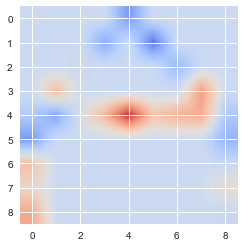


Activation = 0.2295


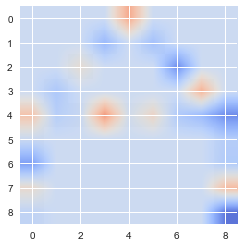


Activation = 0.7737


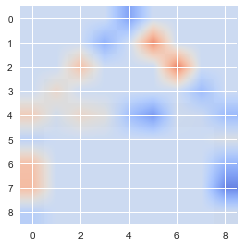


Activation = 0.9862


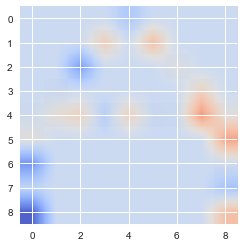


Activation = 0.8292


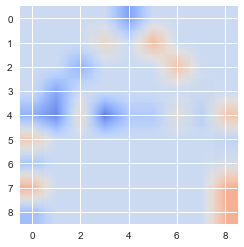


Activation = 0.0797


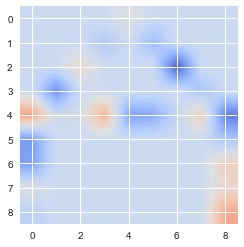


Activation = 0.9799


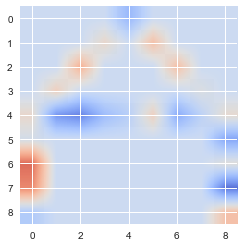


Activation = 0.0093


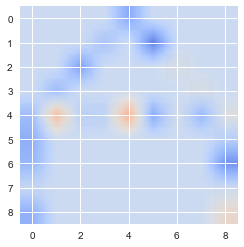

Weights for Node 0


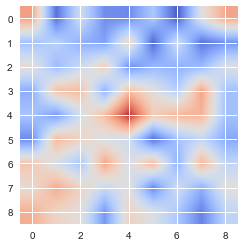

Activation = 0.9939


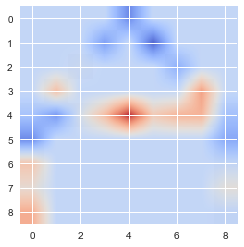

Activation = 0.9788


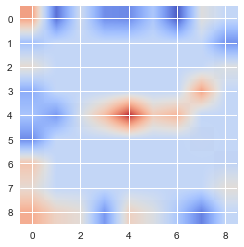

Activation = 0.4314


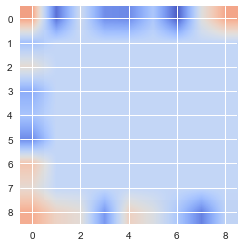

Activation = 0.0128


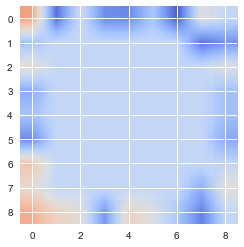

Activation = 0.9892


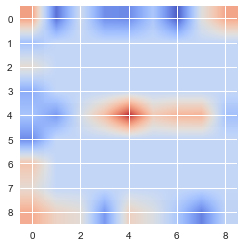

Activation = 0.9892


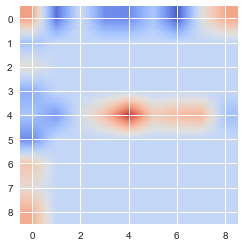

Activation = 0.3247


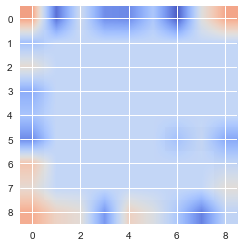

Activation = 0.9994


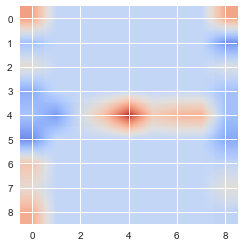

Activation = 0.7801


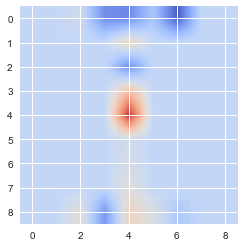

Activation = 0.9918


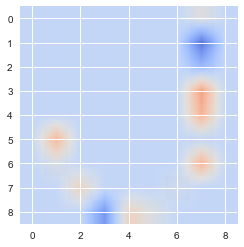

Activation = 0.0733


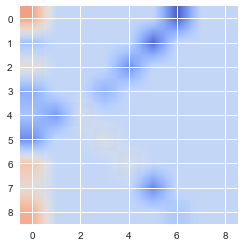

Activation = 0.9227


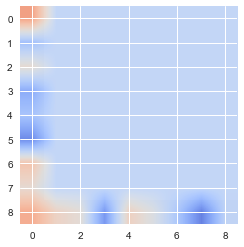

Activation = 0.9967


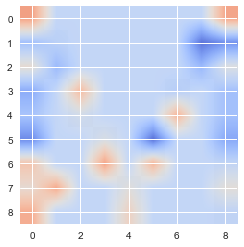

Activation = 0.8396


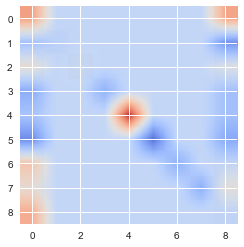

Activation = 0.0021


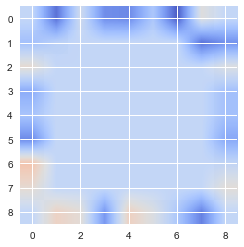

Activation = 0.9758


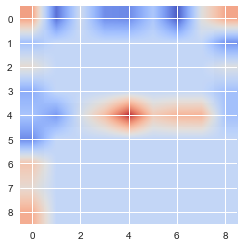

Activation = 0.0225


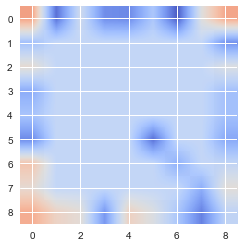

Activation = 0.8193


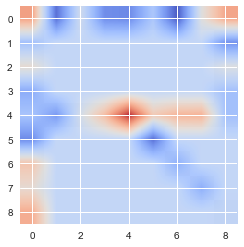

Activation = 0.9810


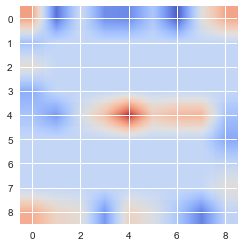

Activation = 0.6786


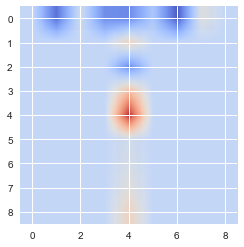

Activation = 0.9808


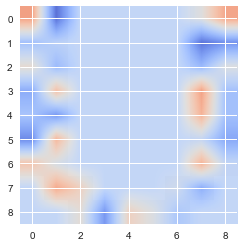

Activation = 0.9813


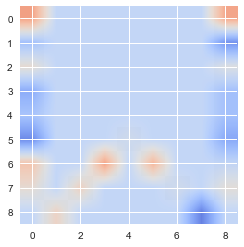

Activation = 0.9590


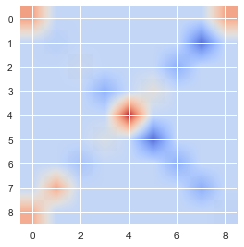

Activation = 0.8723


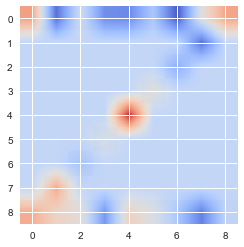

Weights for Node 1


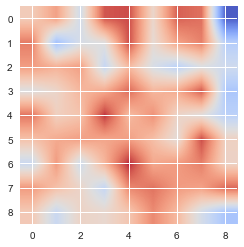

Activation = 0.2295


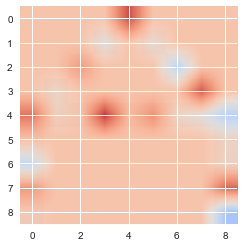

Activation = 0.9753


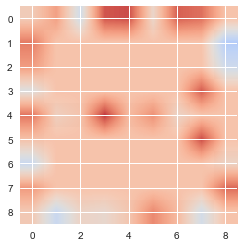

Activation = 0.1319


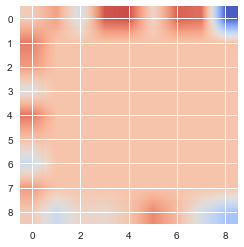

Activation = 0.2633


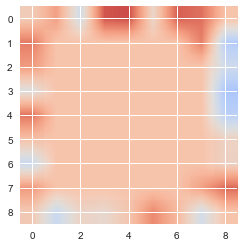

Activation = 0.0991


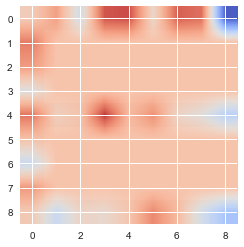

Activation = 0.6573


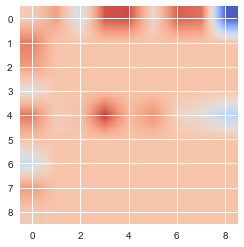

Activation = 0.2733


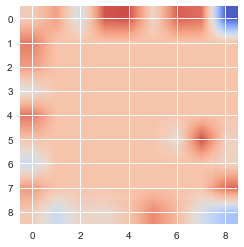

Activation = 0.0015


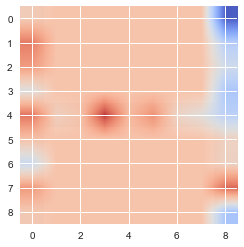

Activation = 0.9972


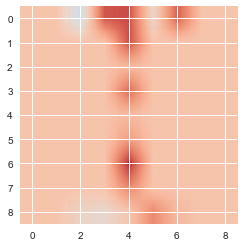

Activation = 0.9749


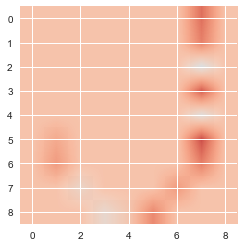

Activation = 0.9667


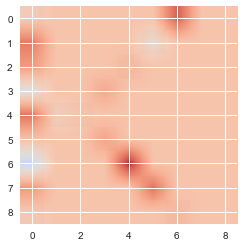

Activation = 0.0710


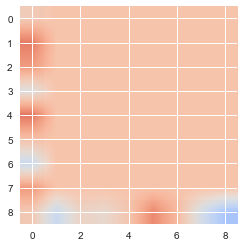

Activation = 0.0011


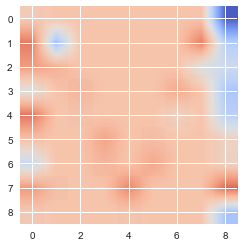

Activation = 0.0010


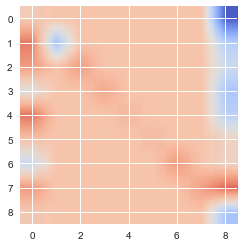

Activation = 0.0830


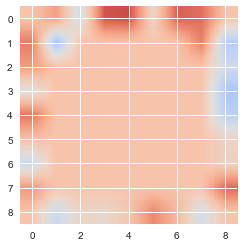

Activation = 0.0791


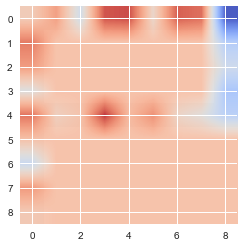

Activation = 0.0075


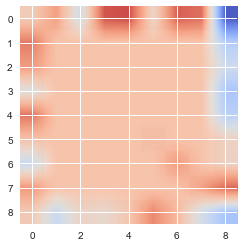

Activation = 0.0532


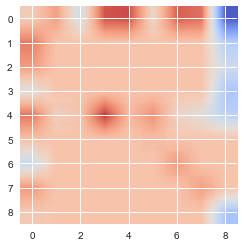

Activation = 0.1842


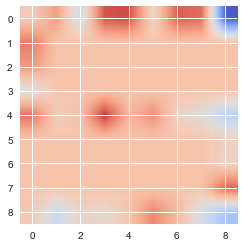

Activation = 0.9991


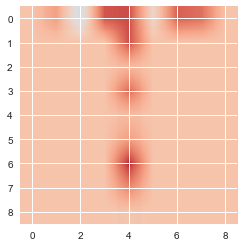

Activation = 0.0146


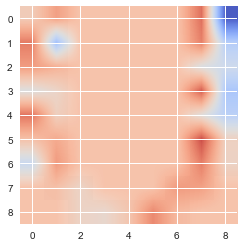

Activation = 0.0016


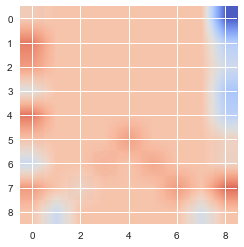

Activation = 0.0091


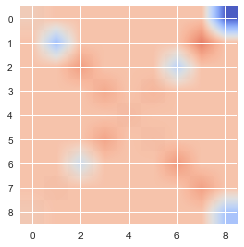

Activation = 0.0326


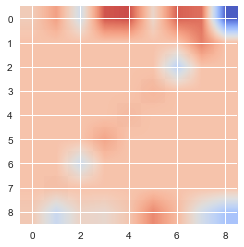

Weights for Node 2


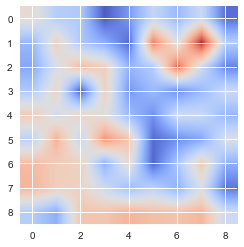

Activation = 0.7737


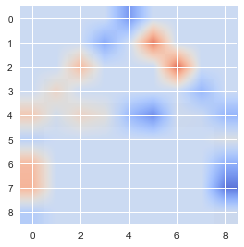

Activation = 0.0395


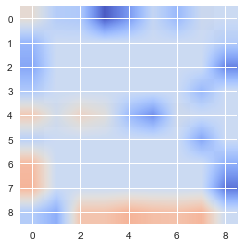

Activation = 0.5275


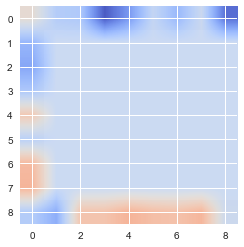

Activation = 0.5201


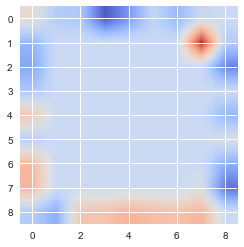

Activation = 0.3089


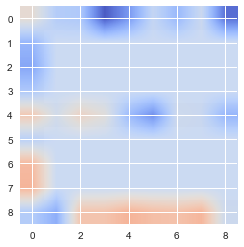

Activation = 0.0085


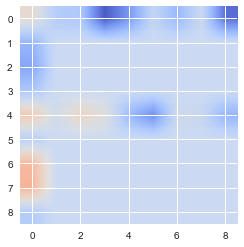

Activation = 0.0489


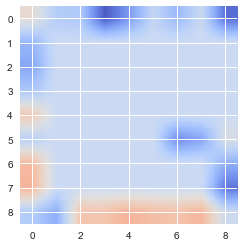

Activation = 0.0138


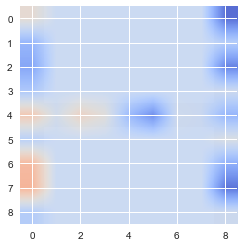

Activation = 0.1235


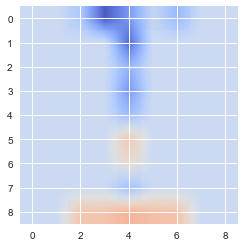

Activation = 0.9910


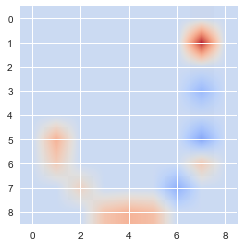

Activation = 0.9808


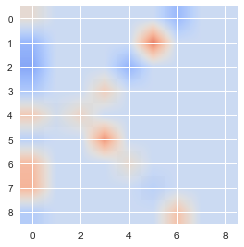

Activation = 0.9880


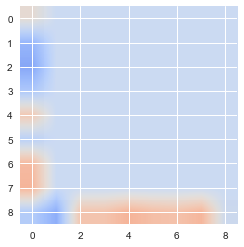

Activation = 0.0223


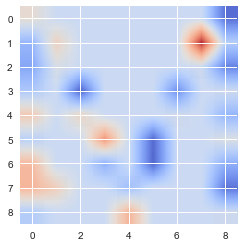

Activation = 0.0225


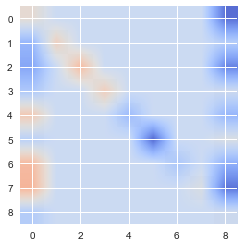

Activation = 0.5644


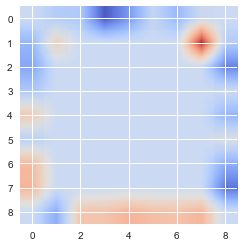

Activation = 0.0027


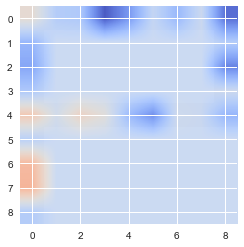

Activation = 0.0123


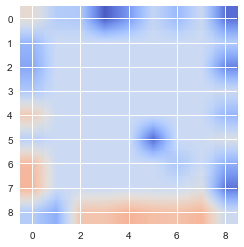

Activation = 0.0007


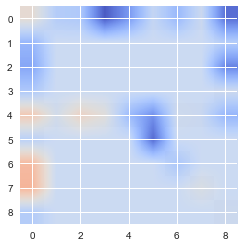

Activation = 0.0219


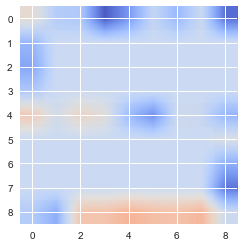

Activation = 0.0069


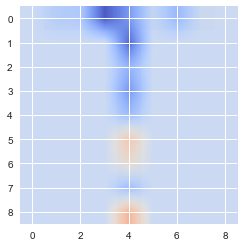

Activation = 0.9918


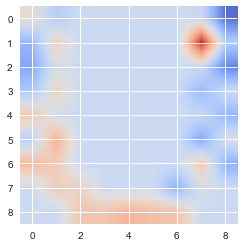

Activation = 0.0096


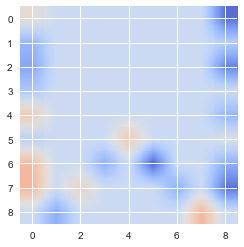

Activation = 0.9771


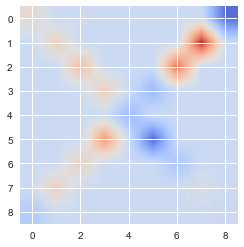

Activation = 0.9820


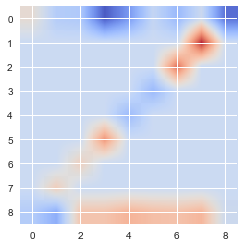

Weights for Node 3


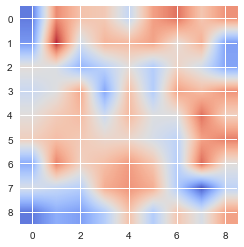

Activation = 0.9862


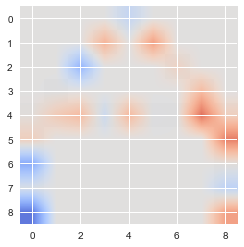

Activation = 0.1367


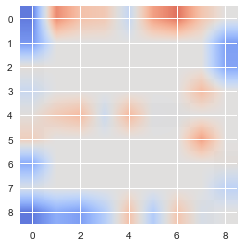

Activation = 0.4452


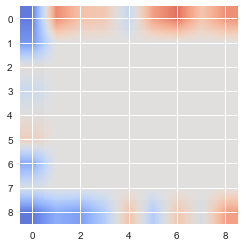

Activation = 0.0451


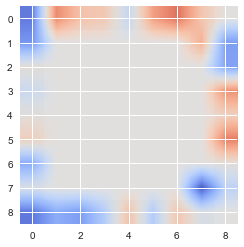

Activation = 0.9249


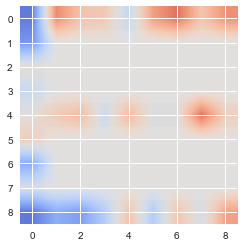

Activation = 0.9800


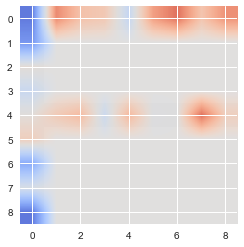

Activation = 0.7213


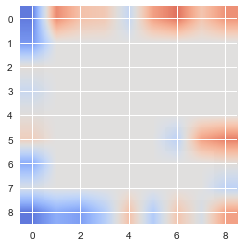

Activation = 0.5794


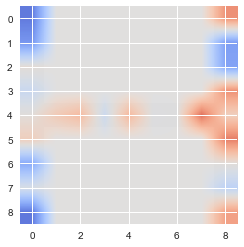

Activation = 0.9979


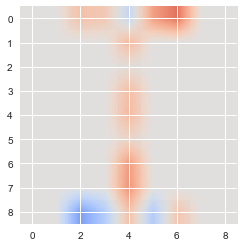

Activation = 0.9971


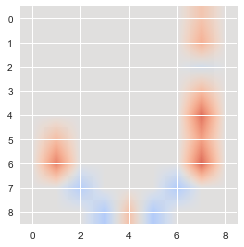

Activation = 0.5933


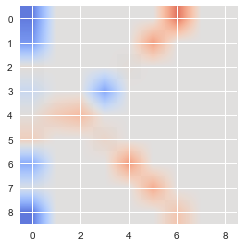

Activation = 0.0054


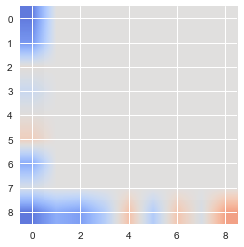

Activation = 0.9866


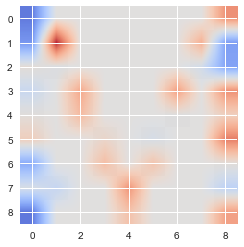

Activation = 0.0186


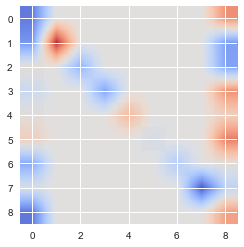

Activation = 0.9554


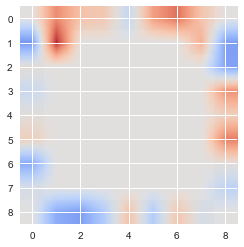

Activation = 0.9412


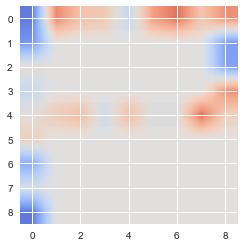

Activation = 0.0718


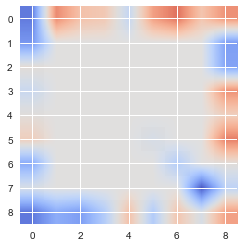

Activation = 0.7879


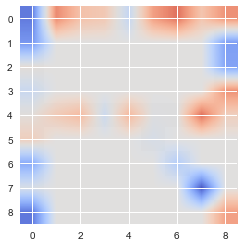

Activation = 0.9823


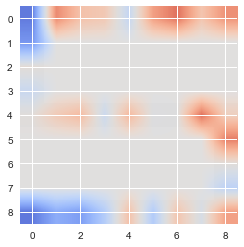

Activation = 0.9999


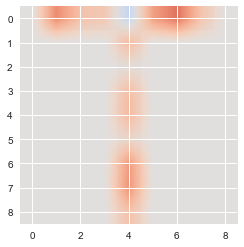

Activation = 0.9843


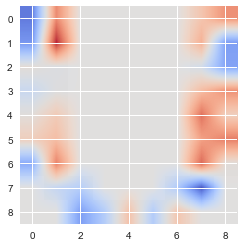

Activation = 0.0833


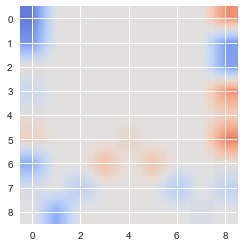

Activation = 0.2111


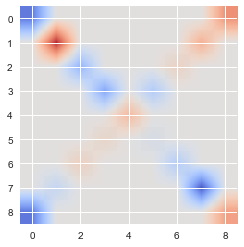

Activation = 0.9504


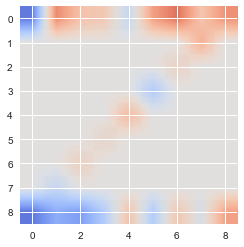

Weights for Node 4


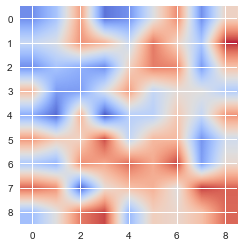

Activation = 0.8292


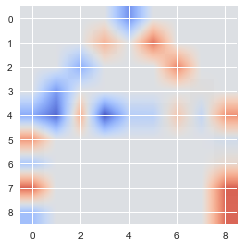

Activation = 0.5762


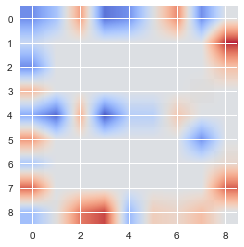

Activation = 0.8064


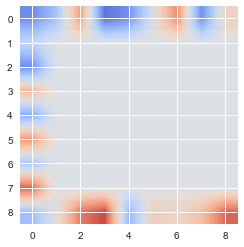

Activation = 0.9832


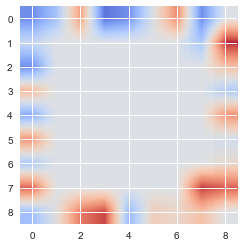

Activation = 0.4979


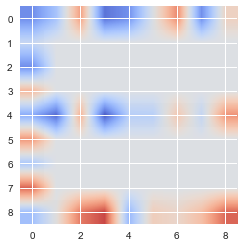

Activation = 0.0345


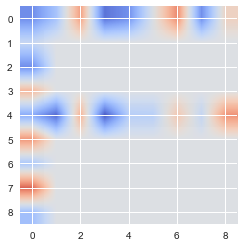

Activation = 0.8949


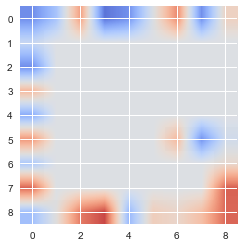

Activation = 0.8411


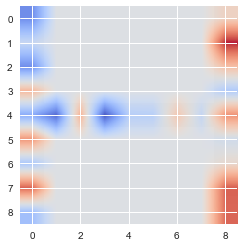

Activation = 0.9791


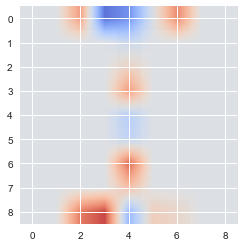

Activation = 0.0327


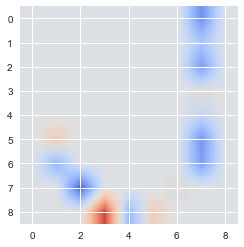

Activation = 0.9746


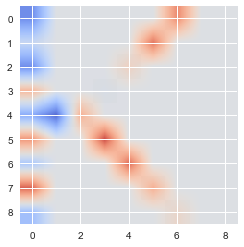

Activation = 0.9460


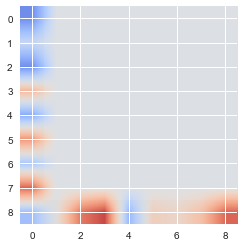

Activation = 0.9970


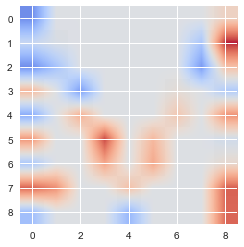

Activation = 0.9965


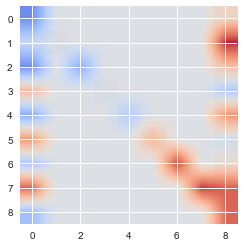

Activation = 0.9853


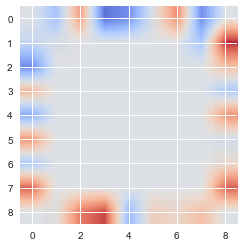

Activation = 0.1163


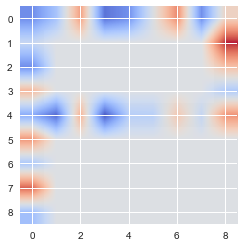

Activation = 0.9993


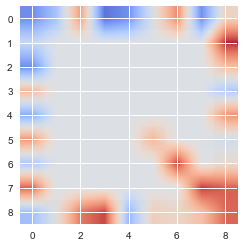

Activation = 0.8489


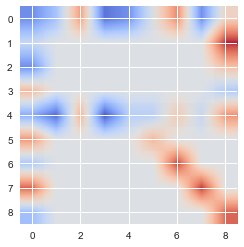

Activation = 0.4355


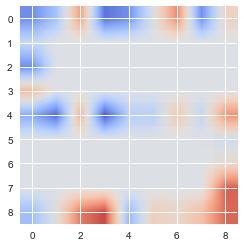

Activation = 0.5358


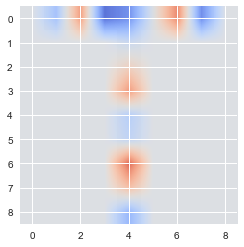

Activation = 0.0718


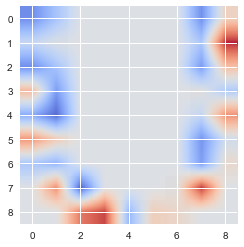

Activation = 0.9747


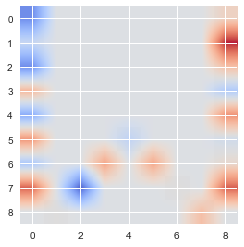

Activation = 0.9950


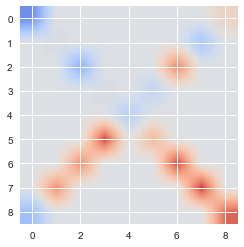

Activation = 0.9789


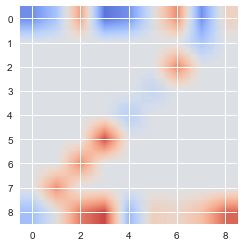

Weights for Node 5


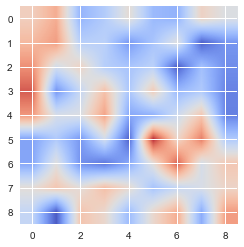

Activation = 0.0797


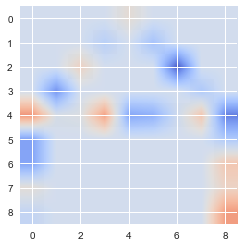

Activation = 0.8823


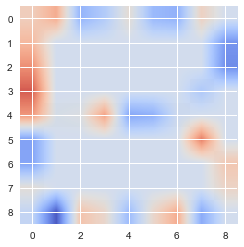

Activation = 0.9750


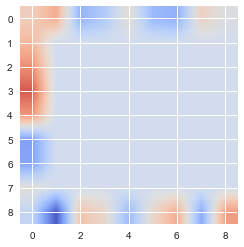

Activation = 0.0670


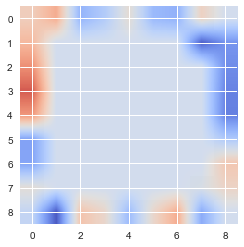

Activation = 0.9389


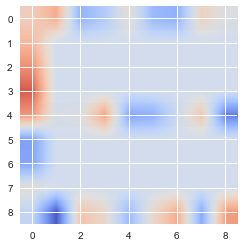

Activation = 0.9010


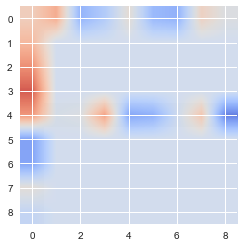

Activation = 0.9976


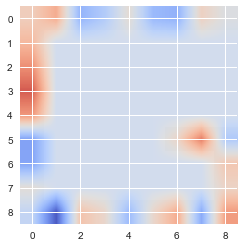

Activation = 0.7990


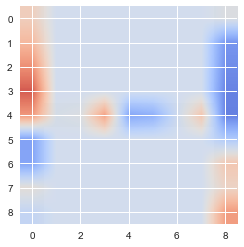

Activation = 0.0085


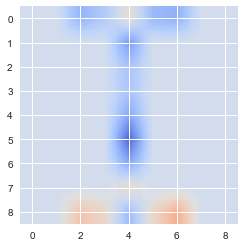

Activation = 0.5580


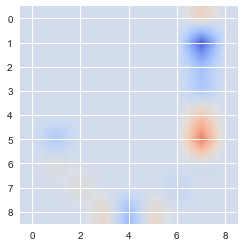

Activation = 0.9309


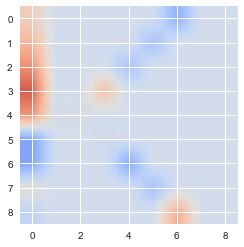

Activation = 0.9850


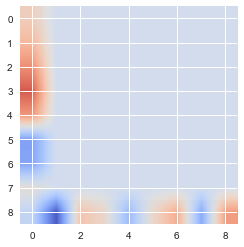

Activation = 0.6952


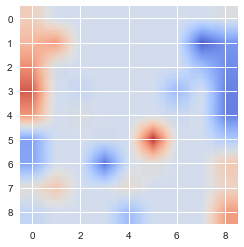

Activation = 0.9976


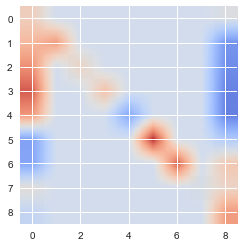

Activation = 0.1178


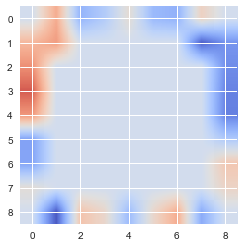

Activation = 0.2687


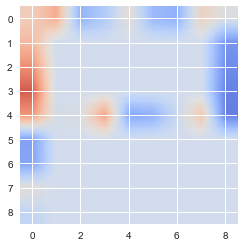

Activation = 0.9692


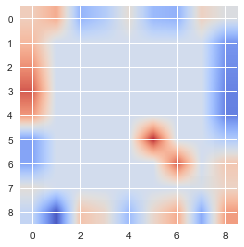

Activation = 0.9731


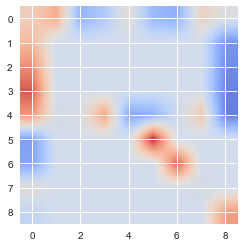

Activation = 0.9920


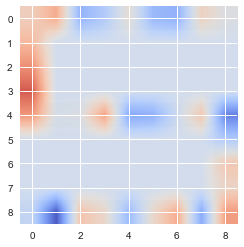

Activation = 0.0034


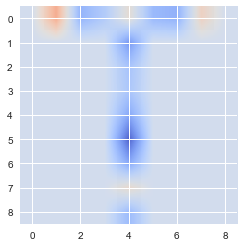

Activation = 0.9562


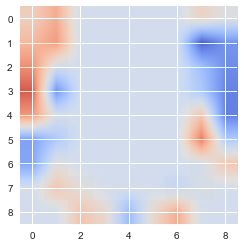

Activation = 0.0118


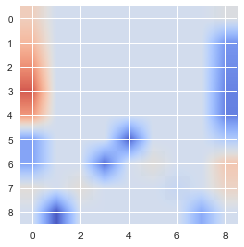

Activation = 0.9771


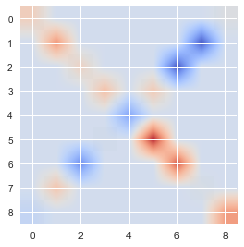

Activation = 0.0408


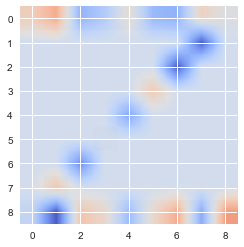

Weights for Node 6


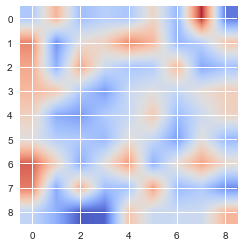

Activation = 0.9799


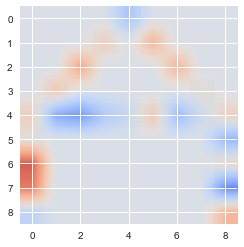

Activation = 0.4534


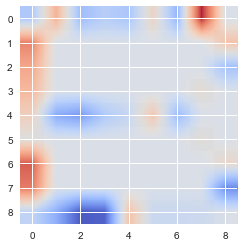

Activation = 0.9290


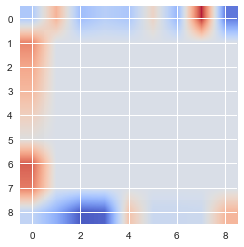

Activation = 0.8210


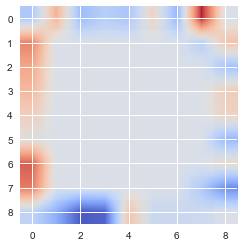

Activation = 0.4923


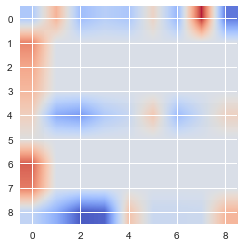

Activation = 0.9639


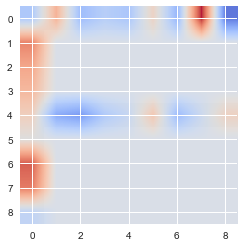

Activation = 0.4808


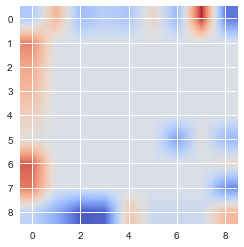

Activation = 0.8934


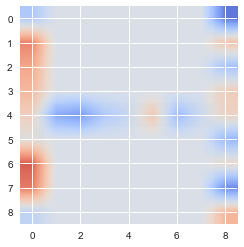

Activation = 0.0354


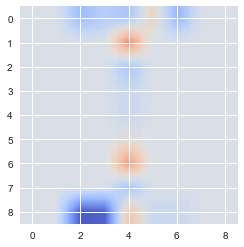

Activation = 0.8504


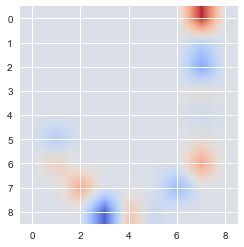

Activation = 0.9857


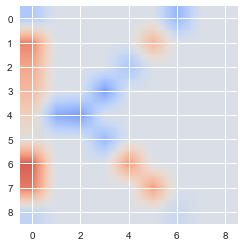

Activation = 0.9649


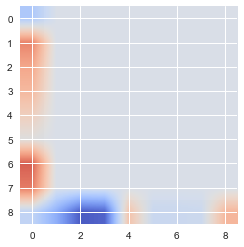

Activation = 0.0330


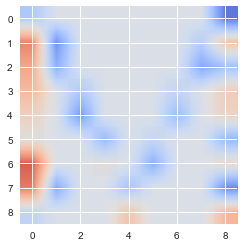

Activation = 0.9620


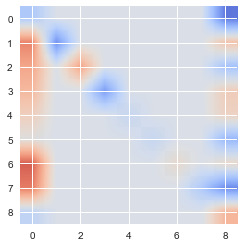

Activation = 0.8350


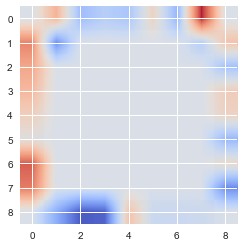

Activation = 0.9777


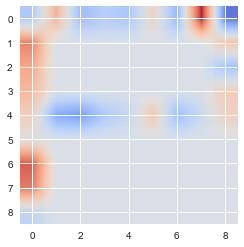

Activation = 0.7870


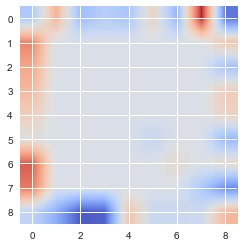

Activation = 0.9844


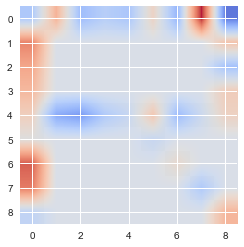

Activation = 0.0078


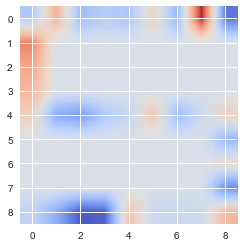

Activation = 0.9610


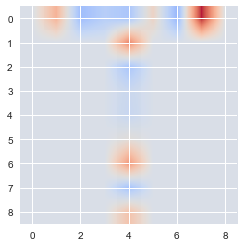

Activation = 0.6311


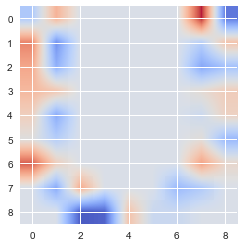

Activation = 0.9631


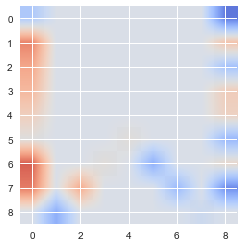

Activation = 0.0101


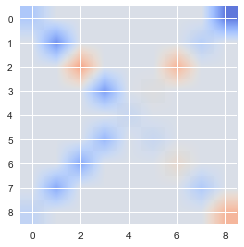

Activation = 0.0018


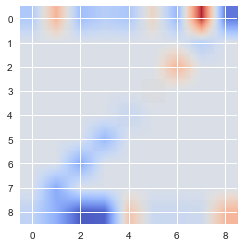

Weights for Node 7


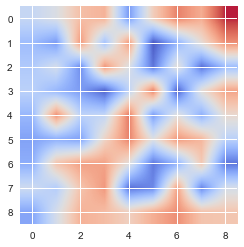

Activation = 0.0093


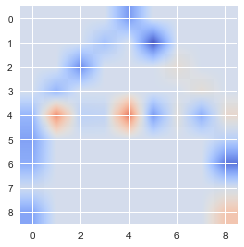

Activation = 0.9929


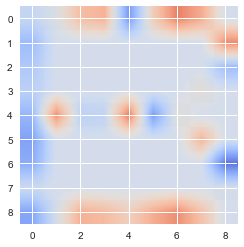

Activation = 0.9960


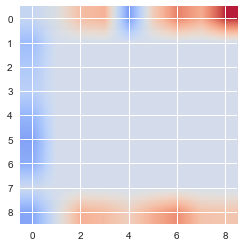

Activation = 0.9649


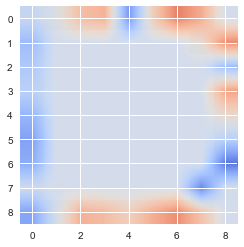

Activation = 0.9980


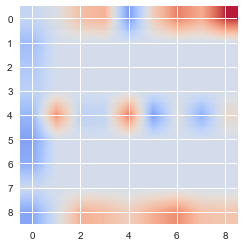

Activation = 0.8944


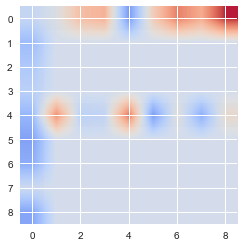

Activation = 0.9969


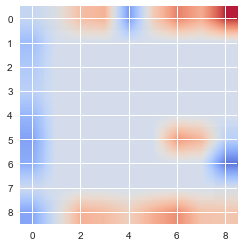

Activation = 0.5247


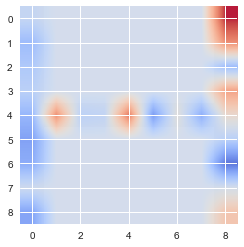

Activation = 0.9996


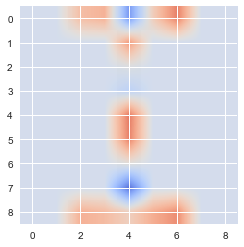

Activation = 0.9861


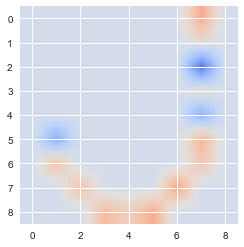

Activation = 0.0759


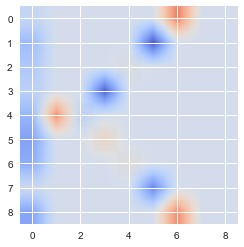

Activation = 0.8287


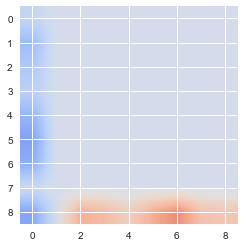

Activation = 0.0123


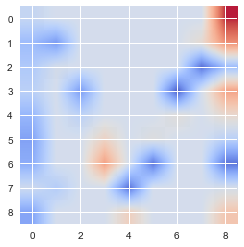

Activation = 0.0380


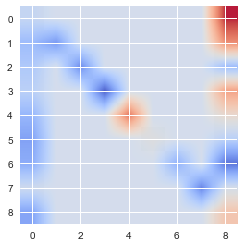

Activation = 0.9853


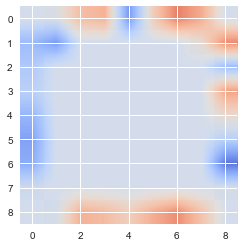

Activation = 0.9666


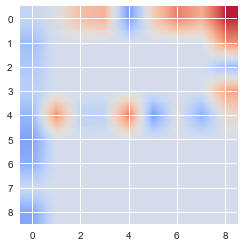

Activation = 0.9894


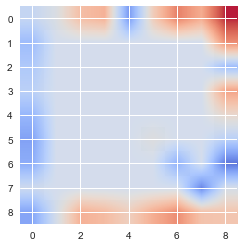

Activation = 0.9276


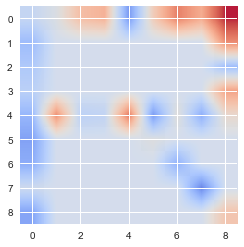

Activation = 0.9982


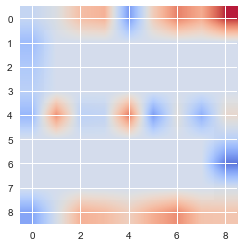

Activation = 0.9967


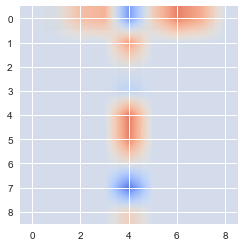

Activation = 0.9647


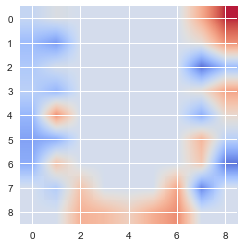

Activation = 0.9120


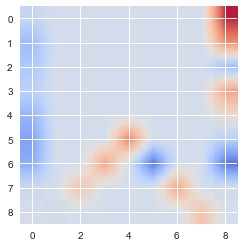

Activation = 0.8008


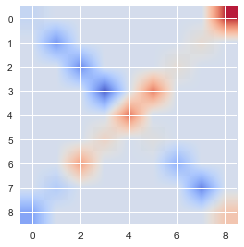

Activation = 1.0000


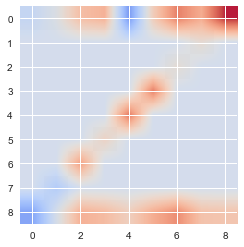

In [81]:
def hidden_activations(data_set, letters, model):

    # Dictionary that will store dataframe input
    hidden_activations = {}

    for i in range(0, data_set.shape[0]):

        # Get correct instance
        forpass = NeuralNet(model.fit.size).forward_pass(data_set[i],
                                                         weights=model.fit.weights,
                                                         biases=model.fit.biases)


        hidden_activations[letters[i]] = forpass.fit.out0.tolist()

    return pd.DataFrame.from_dict(hidden_activations)

#def display_all(case_input):

    for i in range(0, case_input.shape[0]):
        display_letter(case_input[i])

def main():

    # Load data
    training_labels, training_data, letters = process_data()

    # Visualize all letters
    #display_all(training_data)

    # Train model
    final_model1 = NeuralNet((81, 8, 24)).train(training_data, training_labels)

    # Plot each hidden activation for the letter "A"
    display_influence(training_data[0], final_model1)

    for i in range(0, 8):
        display_node(training_data, final_model1, i)

    # Save table of hidden activations
    hidden_activations(training_data, letters, final_model1).to_csv('hidden_activations.csv')

    return final_model1

if __name__ == '__main__':
    final_model = main()